In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image

In [13]:
data_dir = r'C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\mask_cache\train'
batch_size = 64
num_classes = 4
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

# Enable automatic mixed precision training
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


C:\Users\Jatin\AppData\Local\Temp\ipykernel_17624\2472446774.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [14]:
class GaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Increased resolution
    transforms.RandomRotation(45),  # More rotation
    transforms.RandomResizedCrop((128, 128), scale=(0.7, 1.3)),  # More scale variation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # Some medical images might be flipped
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.3,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=45,
        translate=(0.2, 0.2),
        scale=(0.7, 1.3),
        shear=15
    ),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
    GaussianNoise(0., 0.01)  # Slight noise for robustness
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Check for corrupted images and remove them
def check_and_clean_images(data_dir):
    """Check for corrupted images and report them."""
    from PIL import Image
    import os
    
    corrupted_images = []
    data_path = Path(data_dir)
    
    print("Checking for corrupted images...")
    for class_dir in data_path.iterdir():
        if class_dir.is_dir():
            for img_file in class_dir.glob('*.jpg'):
                try:
                    img = Image.open(img_file)
                    img.verify()  # Verify it's a valid image
                except Exception as e:
                    corrupted_images.append(str(img_file))
                    print(f"Corrupted: {img_file}")
    
    if corrupted_images:
        print(f"\nFound {len(corrupted_images)} corrupted images.")
        print("Removing corrupted images...")
        for img_path in corrupted_images:
            try:
                os.remove(img_path)
                print(f"✓ Removed: {img_path}")
            except Exception as e:
                print(f"✗ Could not remove {img_path}: {e}")
        print(f"\n{'='*60}")
        print("⚠️  IMPORTANT: Corrupted images removed!")
        print("📌 Please RE-RUN cells 5-7 to reload the dataset")
        print(f"{'='*60}\n")
    else:
        print("✓ No corrupted images found! Dataset is clean.")
    
    return corrupted_images

# Check and clean the training data
corrupted = check_and_clean_images(data_dir)

if corrupted:
    print(f"\n⚠️  {len(corrupted)} image(s) were removed.")
    print("👉 Next step: Re-run cells 5-7 before training!")

In [15]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# First split the dataset
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1234)
)

# Calculate weights only for training set
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_sample_counts = np.bincount(train_targets)
class_weights = 1. / class_sample_counts
samples_weights = [class_weights[t] for t in train_targets]

In [16]:
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

# Split train/val/test
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1234)
)

In [17]:
# Set validation and test transforms
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Create sampler only for training data
train_sampler = WeightedRandomSampler(weights=samples_weights, 
                                     num_samples=len(samples_weights), 
                                     replacement=True)

# Train loader with sampler (using train_dataset instead of full_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
# Validation & Test loaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

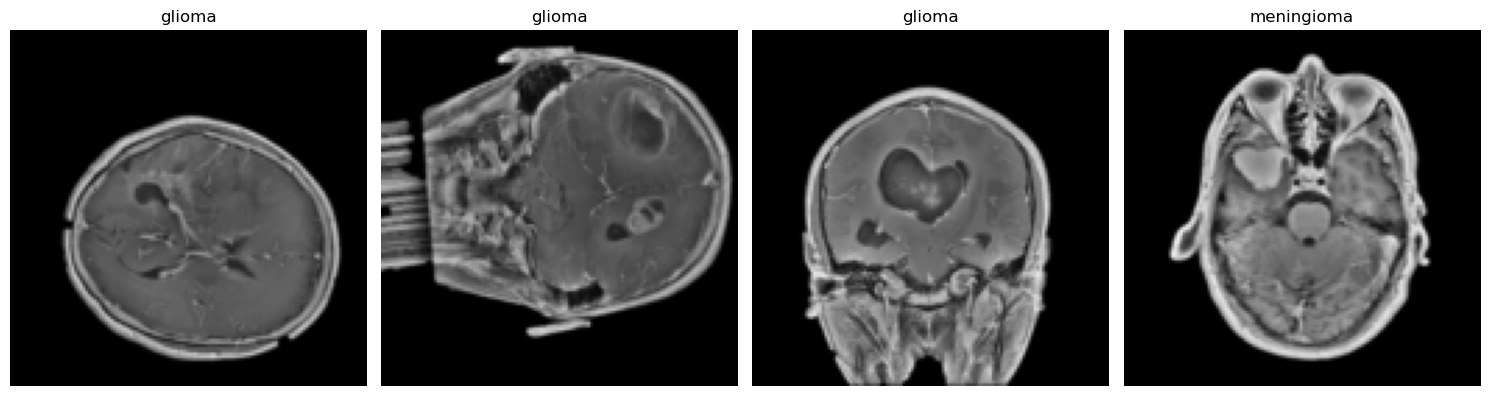

In [18]:
# Visualize sample images
def show_sample_images(dataset, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    if num_images == 1:
        axes = [axes]
    
    for i in range(num_images):
        # Get a random image
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        
        # Convert tensor to numpy for visualization
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        img_np = np.clip(img_np, 0, 1)
        
        # Show image
        axes[i].imshow(img_np)
        axes[i].set_title(f'{full_dataset.classes[label]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some examples
show_sample_images(train_dataset)

In [19]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

# Create model instance
model = BrainTumorCNN(num_classes=num_classes).to(device)

# Weight initialization
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler with warmup
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,  # Warmup for first 20% of training
    div_factor=25,  # LR starts at max_lr/25
    final_div_factor=1000  # Final LR is max_lr/1000
)

In [20]:
# Helper function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
# Training loop
print("Starting training...")

best_val_acc = 0
best_model_state = None
train_losses = []
val_losses = []
train_accs = []
val_accs = []
patience = 10
patience_counter = 0
val_predictions = []
val_targets = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training (updated syntax)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_loop.set_postfix({
            'Loss': f'{running_loss/total:.4f}',
            'Acc': f'{correct/total:.4f}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_true = []
    
    val_loop = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            
            val_loop.set_postfix({
                'Val Loss': f'{val_loss/val_total:.4f}',
                'Val Acc': f'{val_correct/val_total:.4f}'
            })
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save predictions for confusion matrix
    val_predictions = val_preds
    val_targets = val_true
    
    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'brain_tumor_best.pth')
        print(f"New best model saved! Validation Accuracy: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            break

# Load best model and plot final confusion matrix
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation accuracy: {best_val_acc:.4f}")
    
    # Plot final confusion matrix
    plot_confusion_matrix(val_targets, val_predictions, full_dataset.classes)

print("\nTraining completed!")

Starting training...


Epoch 1/30 [Train]:   0%|          | 0/124 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jatin\\Desktop\\oncogenesis\\data\\brain_data\\mask_cache\\train\\glioma\\glioma_mri_010.jpg'

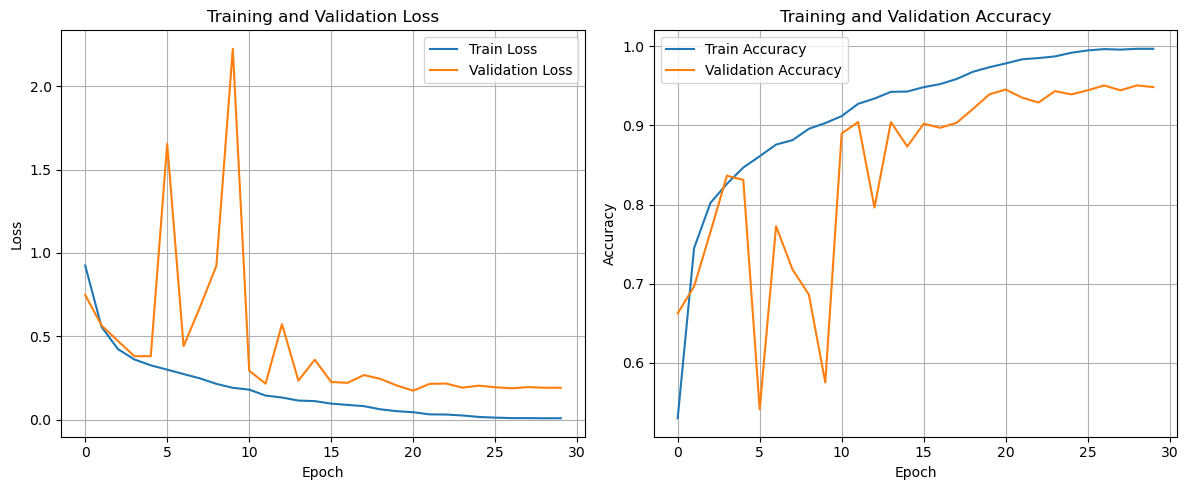

In [11]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Save the trained model with all necessary metadata
save_path = 'brain_tumor_classifier_v1.pth'

# Prepare metadata and model info
model_info = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'image_size': 128,
        'num_classes': num_classes,
        'class_names': full_dataset.classes
    },
    'preprocessing': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225],
        'input_size': 128
    },
    'performance': {
        'best_val_accuracy': best_val_acc,
        'training_loss': train_losses[-1],
        'validation_loss': val_losses[-1],
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1]
    },
    'training_params': {
        'batch_size': batch_size,
        'learning_rate': 0.001,
        'num_epochs': epochs,
        'optimizer': 'AdamW',
        'scheduler': 'OneCycleLR'
    }
}

# Save the model
torch.save(model_info, save_path)
print(f"\nModel saved successfully to {save_path}")
print("\nModel Information:")
print(f"- Input size: 128x128")
print(f"- Number of classes: {num_classes}")
print(f"- Classes: {full_dataset.classes}")
print(f"- Best validation accuracy: {best_val_acc:.4f}")


Model saved successfully to brain_tumor_classifier_v1.pth

Model Information:
- Input size: 128x128
- Number of classes: 4
- Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
- Best validation accuracy: 0.9434


In [ ]:
# Test loading the saved model
def load_model_for_inference(model_path):
    # Load the checkpoint
    checkpoint = torch.load(model_path)
    
    # Create model and load state
    model = BrainTumorCNN(num_classes=checkpoint['model_config']['num_classes'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Create inference transform
    transform = transforms.Compose([
        transforms.Resize((checkpoint['preprocessing']['input_size'],
                         checkpoint['preprocessing']['input_size'])),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=checkpoint['preprocessing']['mean'],
            std=checkpoint['preprocessing']['std']
        )
    ])
    
    return model, transform, checkpoint['model_config']['class_names']

# Verify the saved model
try:
    model_loaded, transform, classes = load_model_for_inference('brain_tumor_classifier_v1.pth')
    print("\nModel loaded successfully!")
    print(f"Available classes: {classes}")
    print("\nModel is ready for making predictions on new images.")
except Exception as e:
    print(f"Error loading model: {str(e)}")